In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
import string
import json
from time import time
import pickle
from collections import Counter
from spacy.lang.en import English

Using TensorFlow backend.


In [3]:
from IPython.display import HTML
HTML('''<script>
code_show_err=false; 
function code_toggle_err() {
 if (code_show_err){
 $('div.output_stderr').hide();
 } else {
 $('div.output_stderr').show();
 }
 code_show_err = !code_show_err
} 
$( document ).ready(code_toggle_err);
</script>
To toggle on/off output_stderr, click <a href="javascript:code_toggle_err()">here</a>.''')

In [4]:
data = pd.read_csv("reddit-data.csv")   # importing csv file

In [5]:
data.head(3)

,title,score,body,url,num_comments,comments,flair,id
0,"Untouchability, even in quarantine. 'We have n...",54,NaN,https://www.telegraphindia.com/india/coronavir...,7,"Let them feel hungry for a couple of days, ma...",Scheduled,fzvwz8
1,Delhi Govt Sources: Names of CM Arvind Kejriwa...,303,NaN,https://twitter.com/ANI/status/123109390051893...,30,This is beyond petty. > The inclusion of a De...,Scheduled,f7ogd8
2,"Delhi: AP Singh, advocate of 2012 Delhi gang-r...",18,NaN,https://twitter.com/ani/status/124073128907587...,21,"My hunch is , this guy is trying to expose th...",Scheduled,flgvah


# Finding where we have Missing Data

In [6]:
data.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 8 columns):
title           2225 non-null object
score           2225 non-null int64
body            1236 non-null object
url             2225 non-null object
num_comments    2225 non-null int64
comments        1975 non-null object
flair           2225 non-null object
id              2225 non-null object
dtypes: int64(2), object(6)
memory usage: 139.1+ KB


1. The graph below shows that there are many null objects in body column, almost half of the values are null. This will lead to huge loss of data while training. So we will not consider body column for training.

2. We can work with comments by removing null objects using data.dropna()

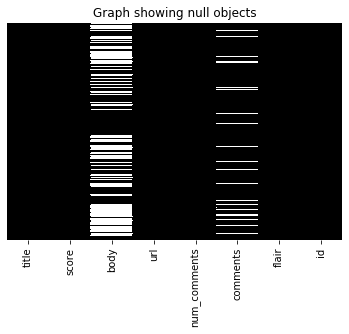

In [7]:
import seaborn as sns
sns.heatmap(data.isnull(),yticklabels=False,cbar = False ,cmap='cubehelix')  # Graph showing null objects
plt.title('Graph showing null objects')
plt.show()

We will be focusing our attention on the “Title”, "url", "comments" columns as they contain the most valuable qualitative information.

# Creating a histogram across flair categories ( To understand distribution of our data )

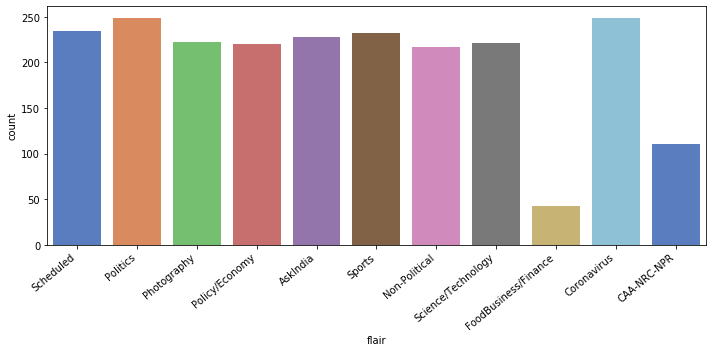

In [8]:
plt.figure(figsize = (10,5))
ax = sns.countplot(x='flair',data=data,palette='muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.tight_layout()
plt.show()

In [9]:
data['flair'].value_counts()

Coronavirus             249
Politics                249
Scheduled               234
Sports                  232
AskIndia                228
Photography             222
Science/Technology      221
Policy/Economy          220
Non-Political           217
CAA-NRC-NPR             111
FoodBusiness/Finance     42
Name: flair, dtype: int64

# Text Preprocessing

In [10]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /Users/apple/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [11]:
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/apple/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [12]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /Users/apple/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [13]:
from nltk.corpus import stopwords
stopwords_set = set(stopwords.words('english'))   
print(stopwords_set) #stopwords set

{'weren', "you're", 'through', "hasn't", 'wouldn', 'below', "doesn't", 'd', "shan't", 'is', 'isn', 'of', "that'll", 'about', 'now', "you'd", 'before', 'both', 'had', 'a', 'for', 'his', 'as', 'yours', 'because', 'can', 'all', 'very', 'couldn', 'ain', 'into', 'not', 'doesn', 'each', 'this', 'aren', "you'll", 'no', 'will', 'hadn', 'just', 'he', 's', 'these', 'ourselves', 'and', 'i', 'more', 'shouldn', "should've", 'yourselves', 'so', 'being', 'off', 'are', 'do', "couldn't", "it's", "mightn't", 'here', 'we', "wasn't", 't', 'doing', 'few', "mustn't", 'it', 'does', 'up', 'at', 'have', 'needn', 'to', "hadn't", 'out', 'don', 'hers', 'll', 'be', 'been', 'some', 'himself', 'by', "didn't", 'our', 'above', 'under', "don't", 'm', 'against', 'during', 'they', 'with', 'your', 'whom', 'further', 'them', 'themselves', 'did', 'she', 'am', "shouldn't", 'that', 'any', "haven't", 'other', 'same', 'yourself', "you've", 'the', 'but', 'again', "won't", 'between', 'over', 'why', 'which', 'itself', 'were', 'hav

In [14]:
from nltk.stem.wordnet import WordNetLemmatizer 
wnl = WordNetLemmatizer()

In [15]:
def lemmatise(sent):
    """
    Performs lemmatization of text
    """
    sent = nltk.tag.pos_tag(sent)
    sent = [(w,get_wordnet_pos(p)) for (w,p) in sent]
    sent = [wnl.lemmatize(w,tag) for (w,tag) in sent]
    return sent

def get_wordnet_pos(tag):
    """
    returns part_of_speech tag to lemmatizer in 'wordnet' format for lemmatization
    """
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [16]:
def text_cleaning(sent):
    sent = sent.lower()   #converting to lower case
    sent = re.sub("[^a-zA-Z]+|(pdf|html|www|http|jpg|com)"," ",sent) # removing numbers and punctuation
    sent = sent.split()
    
    sent = [w for w in sent if len(w)>1] # removing words of length 1 
    sent = [w for w in sent if w not in stopwords_set] # removing stopwords
    sent = lemmatise(sent)    # lemmatization
    sent = " ".join(sent)
    return sent

# Text Preprocessing of Titles

In [17]:
data['title_new'] = data['title'].apply(text_cleaning)

In [18]:
print("old --> ",data['title'][105],"\n\nnew --> ",data['title_new'][105])

old -->  Refrain from using word Dalit, stick to Scheduled Caste: I&B Ministry to media 

new -->  refrain use word dalit stick schedule caste ministry medium


# Text preprocessing of comments

In [19]:
data['comments'].fillna("").apply(len).describe(percentiles=[.96,.25,.75])

count      2225.000000
mean       3252.241798
std       22104.211730
min           0.000000
25%         186.000000
50%         866.000000
75%        2449.000000
96%        9902.120000
max      634435.000000
Name: comments, dtype: float64

some comments are very long the longest being 5,56,983. So, I will limit comments to 10,000 characters which will still completely cover 96% of comments i.e 96% of comments will remain as it is.

In [21]:
def clear_comments(comment):       # function to limit comment length to 10000 characters
    if(len(comment) > 10000):
        return comment[:10000]
    return comment

In [22]:
data['comments_new'] = data['comments'].fillna("").apply(clear_comments).apply(text_cleaning)

After Processing:

In [23]:
data['comments_new'].fillna("").apply(len).describe()

count    2225.000000
mean     1176.175730
std      1565.674943
min         0.000000
25%       114.000000
50%       512.000000
75%      1501.000000
max      6900.000000
Name: comments_new, dtype: float64

In [24]:
print("old --> ",data['comments'][6],"\n\nnew --> ",data['comments_new'][6])

old -->   AFAIK, U.S. still hasn't banned entries of Indian citizens so that shouldn't be an issue. But check with the airline he will be flying and check the advisories of the country he will be transiting through. Like Qatar Airways has banned Indians from flying.

Edit: Qatar Airways hasn't banned Indians. You can still transit through Doha. But Indians are not allowed to enter Qatar. Maybe 

new -->  afaik still ban entry indian citizen issue check airline fly check advisory country transit like qatar airway ban indian fly edit qatar airway ban indian still transit doha indian allow enter qatar maybe


# Text preprocessing of url

Text cleaning of url requires extracting meaningful words from url and removing all the noise like (www, https, jpg, .com , etc.) such words are very common and do not help in distinguishing among different flairs 

In [25]:
def regex_on_url(text):    # custom regex to extract of only meaningful words from url
    return re.sub("(https://)|[a-z.]+(com)|[^a-zA-Z]|(pdf|html|www|http|jpg)",' ',text)

def clean_url(text):
    text = text.lower()       # converting to lowercase
    text = regex_on_url(text) # regex
    text = text.split()
    
    text = [w for w in text if len(w)>1] # removing words of length 1 
    text = [w for w in text if w not in stopwords_set] # removing stopwords
    text = " ".join(text)
    return text



In [26]:
data['url_new'] = data['url'].apply(clean_url)

In [27]:
print("old --> ",data['url'][100],"\n\nnew --> ",data['url_new'][100])

old -->  https://www.reddit.com/r/india/comments/85peql/i_subscribed_to_scripbox_3_months_ago_and_since/ 

new -->  india comments peql subscribed scripbox months ago since


In [28]:
data['title'] = data['title_new']
data['comments'] = data['comments_new']
data['url'] = data['url_new']
data = data.drop(['title_new','comments_new','url_new'],axis = 1) 
data.head(5)

,title,score,body,url,num_comments,comments,flair,id
0,untouchability even quarantine never take food...,54,NaN,india coronavirus outbreak untouchability even...,7,let feel hungry couple day max week care cook ...,Scheduled,fzvwz8
1,delhi govt source names cm arvind kejriwal dep...,303,NaN,ani status,30,beyond petty inclusion delhi government school...,Scheduled,f7ogd8
2,delhi ap singh advocate delhi gang rape convic...,18,NaN,ani status,21,hunch guy try expose loophole legal system nev...,Scheduled,flgvah
3,supreme court verdict sc st quota create polit...,109,NaN,scroll article supreme courts verdict sc st qu...,47,muslim reservation two distraction use indian ...,Scheduled,f1o839
4,entrance exam schedule may,12,"CLAT, AILET, NEET, JEE have been postponed bu...",india comments fvcvo entrance exams scheduled may,3,bachega india tabhi toh padhega india gand mar...,Scheduled,fvcvo1


In [29]:
data.to_csv('reddit-data-cleaned.csv', index=False)  # Saving csv file for later use

# Data Analysis

What flairs tell us about scores

In [30]:
df = data.copy()

In [31]:
df['score'].describe(percentiles = [0.96])

count     2225.000000
mean       134.254382
std        663.940357
min          0.000000
50%         26.000000
96%        520.600000
max      17866.000000
Name: score, dtype: float64

In [32]:
# removing scores greater than 500 because there are very few outliers greater than 500.
# These outliers are very large and they squash the boxplot making it unreadable.
df = df[df['score'] < 500]

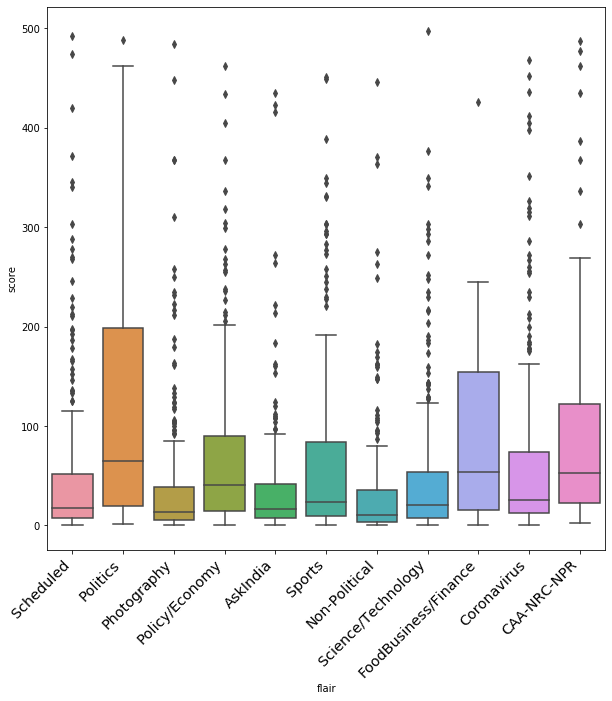

In [33]:
plt.figure(figsize = (10,10))
graph = sns.boxplot(x = df['flair'],y = df['score'])
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

# What flairs tell about num_comments

In [34]:
df = data.copy()

In [35]:
df['num_comments'].describe(percentiles = [.99,.75,.25])

count     2225.000000
mean        46.832809
std        362.925772
min          0.000000
25%          3.000000
50%         10.000000
75%         33.000000
99%        346.800000
max      10942.000000
Name: num_comments, dtype: float64

99% of num_comments are below 400.

So, it makes sense to remove outliers above 400 it would make boxplot readable.

In [36]:
df = df[df['num_comments'] < 400]

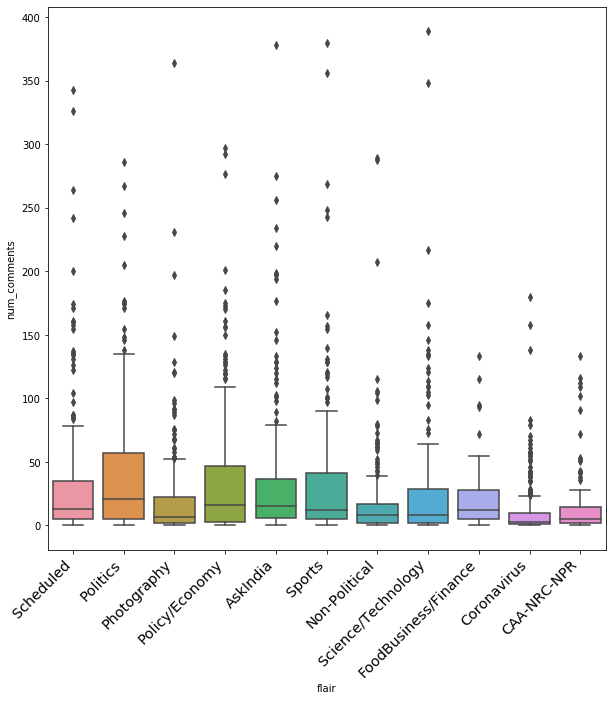

In [37]:
plt.figure(figsize = (10,10))
graph = sns.boxplot(x = df['flair'],y = df['num_comments'])
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

# Lets introduce a new column in dataset "word_length"

word_length column will contain the combined length of (title + url + comments) for each row.

we will use it to study the relation between word_length and flair categories.

In [38]:
df['word_length'] = df[['title','url','comments']].apply(lambda x : ' '.join(x),axis = 1).apply(len)

In [39]:
df.head(5)

,title,score,body,url,num_comments,comments,flair,id,word_length
0,untouchability even quarantine never take food...,54,NaN,india coronavirus outbreak untouchability even...,7,let feel hungry couple day max week care cook ...,Scheduled,fzvwz8,324
1,delhi govt source names cm arvind kejriwal dep...,303,NaN,ani status,30,beyond petty inclusion delhi government school...,Scheduled,f7ogd8,1301
2,delhi ap singh advocate delhi gang rape convic...,18,NaN,ani status,21,hunch guy try expose loophole legal system nev...,Scheduled,flgvah,390
3,supreme court verdict sc st quota create polit...,109,NaN,scroll article supreme courts verdict sc st qu...,47,muslim reservation two distraction use indian ...,Scheduled,f1o839,2069
4,entrance exam schedule may,12,"CLAT, AILET, NEET, JEE have been postponed bu...",india comments fvcvo entrance exams scheduled may,3,bachega india tabhi toh padhega india gand mar...,Scheduled,fvcvo1,243


In [40]:
df['word_length'].describe()

count    2208.000000
mean     1252.626359
std      1508.686168
min        23.000000
25%       237.000000
50%       631.000000
75%      1578.000000
max      6997.000000
Name: word_length, dtype: float64

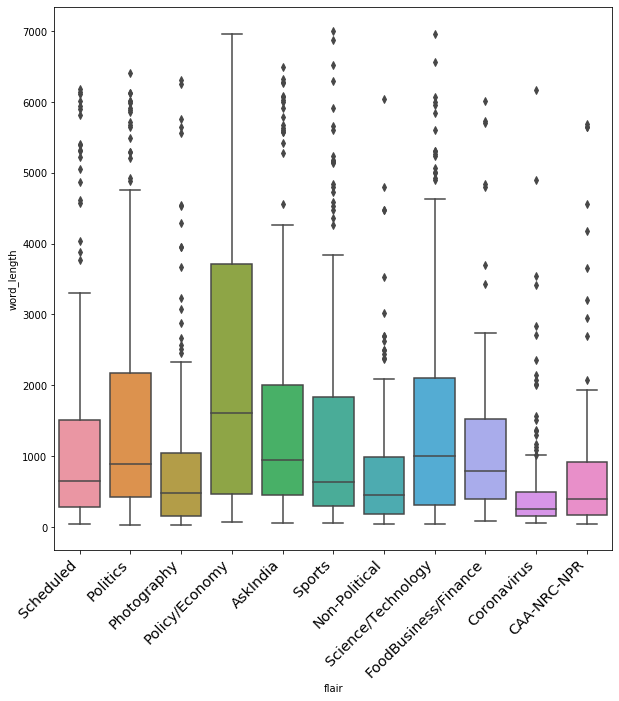

In [41]:
plt.figure(figsize = (10,10))
graph = sns.boxplot(x = df['flair'],y = df['word_length'])
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

# Jointplot of word_length and score

In [42]:
df_without_outliers = df[(df['score'] < 500) & (df['word_length'] < 6000)] # filtering outliers

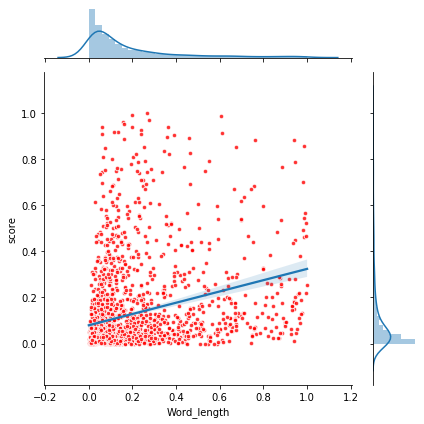

In [43]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(np.reshape(df_without_outliers['word_length'].values,(-1,1)))
Y = scaler.fit_transform(np.reshape(df_without_outliers['score'].values,(-1,1)))

sns.jointplot(x = X,y = Y, kind = 'reg',scatter_kws = {'s':20,'edgecolor':'w','color':'r'})
plt.xlabel('Word_length')
plt.ylabel('score')
plt.tight_layout()
plt.show()

# Jointplot of word_length and num_comments

In [44]:
df[['num_comments','word_length']].describe(percentiles=[.95])

,num_comments,word_length
count,2208.000000,2208.000000
mean,27.616848,1252.626359
std,46.175017,1508.686168
min,0.000000,23.000000
50%,10.000000,631.000000
95%,121.000000,5077.250000
max,389.000000,6997.000000


In [45]:
df_without_outliers = df[(df['num_comments'] < 130) & (df['word_length'] < 6000)]

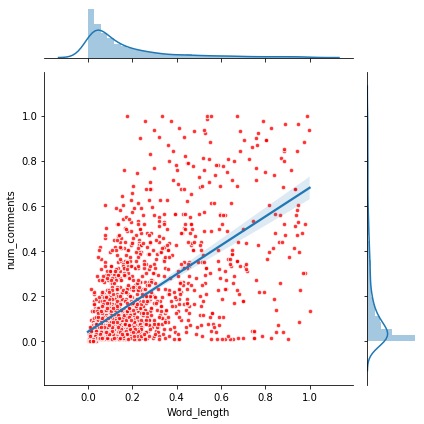

In [46]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(np.reshape(df_without_outliers['word_length'].values,(-1,1)))
Y = scaler.fit_transform(np.reshape(df_without_outliers['num_comments'].values,(-1,1)))

sns.jointplot(x = X,y = Y, kind = 'reg',scatter_kws = {'s':20,'edgecolor':'w','color':'r'})
plt.xlabel('Word_length')
plt.ylabel('num_comments')
plt.tight_layout()
plt.show()

# Content Analysis

In [47]:
# complete_text --> It comprises of all text in our dataset
# First we will join (title + url + comments) for each row in our dataset to get a single column of text.
# Then we will join all values in the column to get a single variable containing full text. 
complete_text = df[['title','url','comments']].apply(lambda x: ' '.join(x),axis = 1)
complete_text = ' '.join(complete_text.values)

# Most common words in the whole dataset

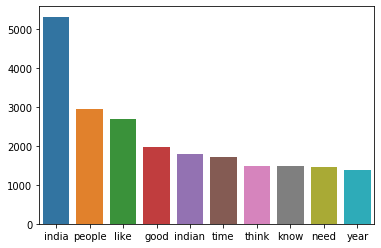

In [48]:
nlp = English()                                                       # Spacy object
nlp.max_length = 3000000
complete_doc = nlp(complete_text)                                     
words = [token.text for token in complete_doc if not token.is_stop]   # list of all words in our dataset 
words_freq = Counter(words)                                           # frequency count 

# Most common 10 words in entire dataset
top_10_words = words_freq.most_common(10)
x = []
y = []
for (word,count) in top_10_words:
    x.append(word)
    y.append(count)
   
sns.barplot(x=x, y=y)

# Finding the most common words in each category

In [49]:
flairs = ['Scheduled', 'Politics', 'Photography', 'Policy/Economy','AskIndia', 'Sports', 'Non-Political', 'Science/Technology','FoodBusiness/Finance', 'Coronavirus', 'CAA-NRC-NPR']
complete_text_for_each_flair = {}   # dictionary which contains complete text (title + url + comments) for each flair
for f in flairs:
    text = df[df['flair'] == f][['title','url','comments']].apply(lambda x : ' '.join(x),axis = 1)
    text = ' '.join(text.values)
    complete_text_for_each_flair[f] = text

In [50]:
print("Top 3 words in each flair are :- ",end = '\n\n')
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    words = [token.text for token in doc if not token.is_stop]
    word_freq = Counter(words)
    top_3_words = word_freq.most_common(3)
    print(f,"-->",top_3_words,end = '\n\n')

Top 3 words in each flair are :- 

Scheduled --> [('india', 433), ('people', 293), ('like', 244)]

Politics --> [('people', 557), ('india', 520), ('bjp', 423)]

Photography --> [('photography', 373), ('india', 342), ('good', 197)]

Policy/Economy --> [('india', 1135), ('economy', 572), ('government', 466)]

AskIndia --> [('india', 611), ('like', 393), ('people', 338)]

Sports --> [('india', 606), ('sport', 559), ('like', 394)]

Non-Political --> [('india', 338), ('political', 306), ('non', 301)]

Science/Technology --> [('india', 659), ('science', 507), ('technology', 363)]

FoodBusiness/Finance --> [('india', 126), ('week', 88), ('good', 80)]

Coronavirus --> [('coronavirus', 452), ('india', 361), ('lockdown', 184)]

CAA-NRC-NPR --> [('caa', 233), ('nrc', 221), ('india', 191)]



# Most flairs have India among its top common words.

these results make sense and indicate that each flair category contains some words that can help distinguish them, for example :-

Scheduled --> 'caste'

Politics --> 'bjp'

Photography --> 'photography'

Policy/Economy --> 'economy'

Sports --> 'sport'

Science/Technology --> 'science', 'technology'

FoodBusiness/Finance --> 'week'

Coronavirus --> 'coronavirus'

CAA-NRC-NPR --> 'caa', 'nrc'

# 5.3 Using dependency parsing to find what India is talking about, what India is doing ?

We will use Spacy's dependecy parsing to find the objects, subjects, verbs for each flair :-

First, we will first find the most common OBJECTS , This will tell us what india is talking about.

Second, we will find the most common VERBS , This will tell us what india is doing.

Third, we will find the most common SUBJECTS, This will tell us about entities in text.

Dependency Parsing

Dependency parsing is the task of extracting grammatical structure of a text, it consists of relations between "root" words and words.

For Example:-

In the example below we show the dependency tree of the sentence - "He is playing football !"
We can see that the words "He", "is", "football!" are all linked to the the VERB playing
The image shows you that the subject of the sentence is the proper noun 'He' and it has a 'play' relationship with object 'football'.

In [51]:
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')
doc = nlp("He is playing football!")
for token in doc:
    print(token.text," ---- ", token.pos_," ---- ", token.head.text," ---- ", token.dep_)
displacy.render(doc,jupyter = True)

He  ----  PRON  ----  playing  ----  nsubj
is  ----  AUX  ----  playing  ----  aux
playing  ----  VERB  ----  playing  ----  ROOT
football  ----  NOUN  ----  playing  ----  dobj
!  ----  PUNCT  ----  playing  ----  punct


We will try to find a similar dependancy relationship for each flair.
We will look for token.dep_ , they tell us about the relationships of each token with its headword. In the example above headword was 'playing'. Generally headwords are VERBS.

We will look at the following dependency labels (token.dep_) for eachtask :-

OBJECT :- dobj (direct-object), obj(object), pobj (object-of-preposition)

VERB :- we will extract headwords

NOUN :- nsubj (nominal-subject), nsubjpass (nominal-subject-passive), csubj (clausal-subject), csubjpass (clausal-
subject-passive)

# 5.3.1 Most common objects

let's see what India is talking about in each flair:-

This sheds some light on topics of discussion in each flair, some observations are very interesting like 'reservation' in Scheduled, 'lockdown' in coronavirus

In [52]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    objects = []
    for token in doc:
        if (token.dep_ == 'dobj' or token.dep_ == 'obj' or token.dep_ == 'pobj'):
            objects.append(token.text)
        

    objects = Counter(objects)
    top_5 = objects.most_common(5)
    print(f,"-->",top_5,end = '\n\n')

Scheduled --> [('time', 49), ('game', 43), ('caste', 40), ('people', 38), ('work', 37)]

Politics --> [('thing', 73), ('people', 68), ('politics', 57), ('india', 55), ('time', 52)]

Photography --> [('photography', 59), ('comments', 38), ('thing', 35), ('work', 32), ('india', 32)]

Policy/Economy --> [('economy', 108), ('india', 98), ('country', 69), ('people', 64), ('time', 62)]

AskIndia --> [('comments', 71), ('time', 63), ('india', 60), ('thing', 59), ('use', 57)]

Sports --> [('sport', 62), ('india', 52), ('comments', 41), ('people', 40), ('thing', 40)]

Non-Political --> [('comments', 35), ('time', 25), ('india', 25), ('thing', 25), ('people', 21)]

Science/Technology --> [('technology', 62), ('india', 45), ('time', 44), ('comments', 43), ('science', 38)]

FoodBusiness/Finance --> [('comments', 15), ('post', 14), ('work', 13), ('thing', 12), ('time', 10)]

Coronavirus --> [('coronavirus', 46), ('lockdown', 29), ('case', 28), ('people', 26), ('india', 19)]

CAA-NRC-NPR --> [('prot

# Random Objects

lets see some random objects, to get a better idea

In [53]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    objects = []
    for token in doc:
         if (token.dep_ == 'dobj' or token.dep_ == 'obj' or token.dep_ == 'pobj'):
            objects.append(token.text)
        

    objects = Counter(objects)
    freq_cnt = dict(objects)
    sorted_verbs = sorted(freq_cnt.items(),key = lambda x : x[1])
    sorted_verbs = [w[0] for w in sorted_verbs if w[1] > 10]
    idx = np.random.randint(0, len(sorted_verbs), size=(5,))
    print(f, " -----> ",end = '')
    for i in idx:
        print(sorted_verbs[i],end = ', ')
       
    print('\n')

Scheduled  -----> call, launch, reservation, love, hope, 

Politics  -----> post, country, point, modi, source, 

Photography  -----> thread, work, experience, experience, life, 

Policy/Economy  -----> findia, inflation, gdp, indian, govt, 

AskIndia  -----> language, year, problem, question, situation, 

Sports  -----> fact, football, work, people, match, 

Non-Political  -----> comments, post, money, time, place, 

Science/Technology  -----> point, science, job, etc, education, 

FoodBusiness/Finance  -----> post, post, work, post, thing, 

Coronavirus  -----> time, help, people, help, day, 

CAA-NRC-NPR  -----> thing, country, protest, source, protest, 



# Most common verbs

let's see what India is doing :-

It's hard to make any inference from this output, the most common actions are very general.
Perhaps this indicates the nature of our text, It mainly consists of people reporting and posting things about India. We can expect that the most common verbs to be the very general ones i.e the ones we mostly use in everyday life.

In [54]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    verbs = []
    for token in doc:
        if (token.dep_ == 'ROOT'):
            if(token.is_stop == False):
                verbs.append(token.text)
        

    verbs = Counter(verbs)
    top_5 = verbs.most_common(5)
    print(f,"-->",top_5,end = '\n\n')

Scheduled --> [('think', 81), ('want', 76), ('know', 68), ('play', 65), ('need', 44)]

Politics --> [('think', 151), ('know', 96), ('want', 83), ('need', 65), ('let', 56)]

Photography --> [('want', 61), ('know', 57), ('look', 56), ('think', 53), ('need', 36)]

Policy/Economy --> [('think', 131), ('know', 96), ('want', 83), ('need', 58), ('mean', 52)]

AskIndia --> [('think', 117), ('know', 112), ('need', 83), ('want', 82), ('try', 70)]

Sports --> [('think', 122), ('know', 71), ('watch', 68), ('want', 61), ('need', 49)]

Non-Political --> [('think', 61), ('want', 47), ('know', 44), ('comments', 24), ('try', 22)]

Science/Technology --> [('think', 84), ('know', 77), ('want', 68), ('need', 58), ('try', 44)]

FoodBusiness/Finance --> [('think', 25), ('know', 21), ('need', 15), ('find', 12), ('want', 11)]

Coronavirus --> [('know', 27), ('think', 23), ('need', 19), ('ask', 17), ('want', 14)]

CAA-NRC-NPR --> [('think', 31), ('know', 18), ('need', 17), ('want', 14), ('let', 12)]



# Random verbs

This provides us a better view of actions that a flair can be involved in

Politics --> speak, win, face

Photography --> comments

Policy/Economy --> suggest, grow, hope

AskIndia --> tell, understand

Sports --> beat

Science/Technology --> write, try

Coronavirus --> use, test

CAA-NRC-NPR --> protest

In [56]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    verbs = []
    for token in doc:
        if (token.dep_ == 'ROOT'):
            if(token.is_stop == False):
                verbs.append(token.text)
        

    verbs = Counter(verbs)
    freq_cnt = dict(verbs)
    sorted_verbs = sorted(freq_cnt.items(),key = lambda x : x[1])
    sorted_verbs = [w[0] for w in sorted_verbs if w[1] > 10]
    idx = np.random.randint(0, len(sorted_verbs), size=(5,))
    print(f, " -----> ",end = '')
    for i in idx:
        print(sorted_verbs[i],end = ', ')
       
    print('\n')

Scheduled  -----> believe, leave, happen, want, try, 

Politics  -----> leave, remain, believe, work, hai, 

Photography  -----> ask, start, let, try, remove, 

Policy/Economy  -----> point, need, cause, create, turn, 

AskIndia  -----> want, start, consider, talk, hope, 

Sports  -----> sport, love, help, play, run, 

Non-Political  -----> feel, mean, live, happen, want, 

Science/Technology  -----> provide, think, let, think, allow, 

FoodBusiness/Finance  -----> know, want, need, know, need, 

Coronavirus  -----> think, want, need, know, think, 

CAA-NRC-NPR  -----> understand, understand, prove, let, know, 



# Most common Subjects

the subject is the part of a sentence that commonly indicates

what it is about

who or what performs the action

In [57]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    subjects = []
    for token in doc:
        if (token.dep_ == 'nsubj' or token.dep_ == 'nsubjpass' or token.dep_ == 'csubj' or token.dep_ == 'csubjpass'):
            if (token.text != 'people' and token.text != 'india'):  # people and india are the most common nouns in the dataset
                subjects.append(token.text)
        

    subjects = Counter(subjects)
    top_5 = subjects.most_common(5)
    print(f,"-->",top_5,end = '\n\n')

Scheduled --> [('anyone', 55), ('thing', 50), ('guy', 45), ('someone', 43), ('comments', 38)]

Politics --> [('bjp', 93), ('politics', 80), ('government', 75), ('thing', 71), ('modi', 71)]

Photography --> [('photography', 57), ('comments', 39), ('work', 34), ('place', 30), ('guy', 29)]

Policy/Economy --> [('government', 171), ('economy', 162), ('modi', 132), ('country', 101), ('thing', 70)]

AskIndia --> [('thing', 90), ('askindia', 70), ('someone', 62), ('life', 60), ('guy', 54)]

Sports --> [('sport', 56), ('someone', 54), ('country', 52), ('thing', 49), ('channel', 43)]

Non-Political --> [('comments', 33), ('guy', 31), ('thing', 29), ('someone', 27), ('friend', 20)]

Science/Technology --> [('technology', 51), ('government', 44), ('help', 44), ('thing', 40), ('science', 39)]

FoodBusiness/Finance --> [('post', 22), ('thing', 16), ('government', 13), ('one', 12), ('bank', 11)]

Coronavirus --> [('coronavirus', 58), ('modi', 30), ('lockdown', 28), ('government', 24), ('case', 20)]


# Random Subjects

In [58]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    subjects = []
    for token in doc:
        if (token.dep_ == 'nsubj' or token.dep_ == 'nsubjpass' or token.dep_ == 'csubj' or token.dep_ == 'csubjpass'):
                subjects.append(token.text)
        

    subjects = Counter(subjects)
    freq_cnt = dict(subjects)
    sorted_verbs = sorted(freq_cnt.items(),key = lambda x : x[1])
    sorted_verbs = [w[0] for w in sorted_verbs if w[1] > 15]
    idx = np.random.randint(0, len(sorted_verbs), size=(5,))
    print(f, " -----> ",end = '')
    for i in idx:
        print(sorted_verbs[i],end = ', ')
       
    print('\n')


Scheduled  -----> woman, family, game, government, everything, 

Politics  -----> everything, politician, statement, post, pm, 

Photography  -----> comments, post, man, job, hobby, 

Policy/Economy  -----> rate, party, people, money, change, 

AskIndia  -----> reason, plan, woman, start, post, 

Sports  -----> money, country, comments, work, everyone, 

Non-Political  -----> help, op, place, anyone, help, 

Science/Technology  -----> pany, someone, science, article, message, 

FoodBusiness/Finance  -----> thing, thing, india, india, post, 

Coronavirus  -----> india, government, india, coronavirus, coronavirus, 

CAA-NRC-NPR  -----> nrc, caa, protest, nrc, caa, 



# Most common Bigrams, Trigrams

Bigrams

A bigram is a made up of two words, every two adjacent words in text create one bigram.

For the sentence, "I like playing football" the bigrams are ----> [ "I like", "like playing", "playing football" ]

Compared with unigrams bigrams can convey more meaning.

We'll extract the most common bigrams

In [59]:
from nltk import bigrams, trigrams   # using nltk

In [60]:
nlp = English()                     
nlp.max_length = 3000000
complete_doc = nlp(complete_text)
unigrams = [token.text for token in complete_doc if not token.is_stop]     # creating list of all unigrams (words)


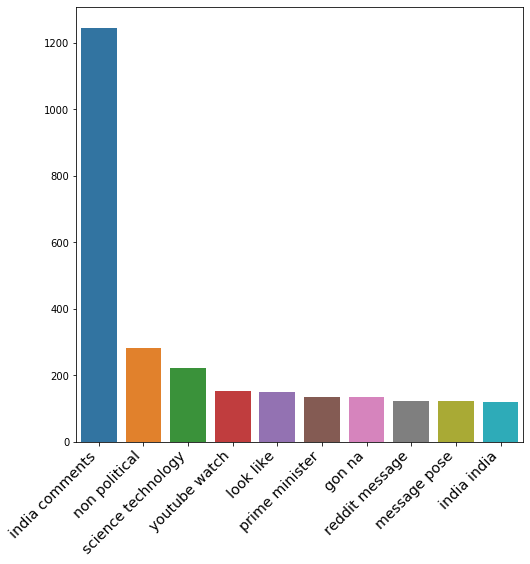

In [61]:
bi_grams = bigrams(unigrams)            # bi_grams --> generator object containing bigrams
bigram_list = []
temp = [w for w in bi_grams]
for x in temp:                          # creating list of bigrams
    y = x[0]+' '+x[1]
    bigram_list.append(y)               
   
bigram_freq = Counter(bigram_list)
bigram_top = bigram_freq.most_common(10)
x = []
y = []
for element in bigram_top:
    x.append(element[0])
    y.append(element[1])
   
plt.figure(figsize=(8,8))
sns.barplot(x = x,y = y)
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

In [62]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    unigrams = [token.text for token in doc if not token.is_stop]
    bi_grams = bigrams(unigrams)
    bigram_list = []
    temp = [w for w in bi_grams]
    for x in temp:
        y = x[0]+' '+x[1]
        bigram_list.append(y)

    bigram_freq = Counter(bigram_list)
    bigram_top = bigram_freq.most_common(6)
    print(f,"  ----->  ",bigram_top,end = '\n\n\n')

Scheduled   ----->   [('india comments', 155), ('youtube watch', 60), ('daily discussion', 40), ('schedule caste', 39), ('random daily', 39), ('sc st', 36)]


Politics   ----->   [('india comments', 90), ('political party', 38), ('look like', 38), ('shiv sena', 34), ('amit shah', 32), ('hindu muslim', 30)]


Photography   ----->   [('india comments', 139), ('photography thread', 75), ('weekly photography', 67), ('thread thread', 54), ('look like', 24), ('youtube channel', 21)]


Policy/Economy   ----->   [('india comments', 141), ('indian economy', 75), ('prime minister', 51), ('long term', 51), ('narendra modi', 47), ('modi government', 45)]


AskIndia   ----->   [('india comments', 222), ('self post', 19), ('india india', 18), ('long time', 17), ('year ago', 16), ('good luck', 16)]


Sports   ----->   [('india comments', 132), ('star sport', 40), ('world cup', 34), ('virat kohli', 24), ('india india', 22), ('social medium', 20)]


Non-Political   ----->   [('non political', 265), ('i

## Trigrams

Trigram is a collection of three words, every three adjacent words make up one trigram

For the sentence, "I like playing football" the trigrams are ----> [ "I like playing", "like playing football" ]

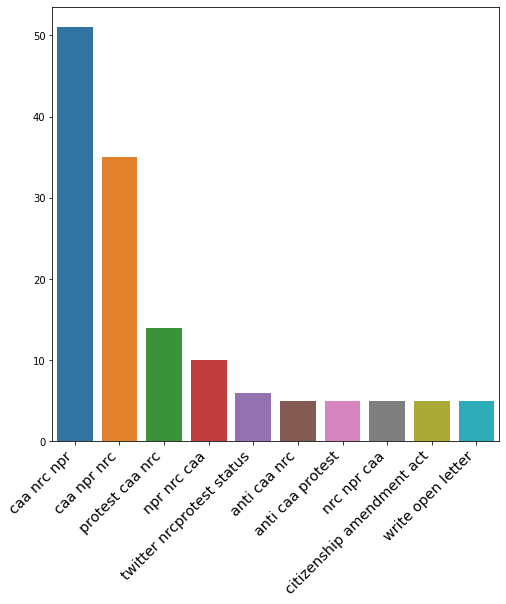

In [63]:
tri_grams = trigrams(unigrams)
trigram_list = []
temp = [w for w in tri_grams]
for x in temp:
    y = x[0]+' '+x[1]+' '+x[2]
    trigram_list.append(y)
   
trigram_freq = Counter(trigram_list)
trigram_top = trigram_freq.most_common(10)
x = []
y = []
for element in trigram_top:
    x.append(element[0])
    y.append(element[1])
   
plt.figure(figsize=(8,8))
sns.barplot(x = x,y = y)
plt.xticks(rotation=45, horizontalalignment='right',fontweight='light',fontsize='x-large')
plt.show()

In [64]:
for f in flairs:
    doc = nlp(complete_text_for_each_flair[f])
    unigrams = [token.text for token in doc if not token.is_stop]
    tri_grams = trigrams(unigrams)
    trigram_list = []
    temp = [w for w in tri_grams]
    for x in temp:
        y = x[0]+' '+x[1]+' '+x[2]
        trigram_list.append(y)

    trigram_freq = Counter(trigram_list)
    trigram_top = trigram_freq.most_common(5)
    print(f," -----> ",trigram_top,end = '\n\n\n')

Scheduled  ----->  [('random daily discussion', 39), ('schedule india comments', 33), ('thread schedule india', 27), ('daily discussion morning', 20), ('discussion morning thread', 20)]


Politics  ----->  [('en wikipedia org', 9), ('wikipedia org wiki', 9), ('indiatoday india story', 9), ('politics india comments', 8), ('bharat mata ki', 8)]


Photography  ----->  [('weekly photography thread', 67), ('photography thread thread', 54), ('reddit india ments', 14), ('thread thread december', 10), ('thread thread september', 10)]


Policy/Economy  ----->  [('reddit message pose', 38), ('article adblocker unfriendly', 22), ('adblocker unfriendly follow', 22), ('unfriendly follow text', 22), ('follow text article', 22)]


AskIndia  ----->  [('india india comments', 15), ('askindia india comments', 13), ('en wikipedia org', 8), ('reddit india ments', 8), ('low effort political', 7)]


Sports  ----->  [('india india comments', 19), ('star sport select', 10), ('accidental prime minister', 9), (